# Example emulation of PROSAIL using ``gp_emulator``

## J  Gomez-Dans (NCEO & UCL)

The purpose of this notebook is to demonstrate the emulation (and part validation) of the PROSAIL model using the simple GP library produced by UCL. We use the PROSAIL model for convenience: it's fast even on a laptop. A similar approach can be taken with other models of course. You can install the ``gp_emulator`` library directly from the internet using ``pip``. Just execute the next code cell.

In [1]:
! pip install --user https://github.com/jgomezdans/gp_emulator/zipball/master

You are using pip version 7.1.0, however version 7.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
     - 151kB 750kB/s
  Found existing installation: gp-emulator 1.4.4
    DEPRECATION: Uninstalling a distutils installed project (gp-emulator) has been deprecated and will be removed in a future version. This is due to the fact that uninstalling a distutils project will only partially uninstall the project.
    Uninstalling gp-emulator-1.4.4:
      Successfully uninstalled gp-emulator-1.4.4
  Running setup.py install for gp-emulator


In [31]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
%matplotlib inline
import sys
sys.path.append ( "..")
import gp_emulator


def plot_config ():
    """Update the MPL configuration"""
    config_json='''{
            "lines.linewidth": 2.0,
            "axes.edgecolor": "#bcbcbc",
            "patch.linewidth": 0.5,
            "legend.fancybox": true,
            "axes.color_cycle": [
                "#FC8D62",
                "#66C2A5",
                "#8DA0CB",
                "#E78AC3",
                "#A6D854",
                "#FFD92F",
                "#E5C494",
                "#B3B3B3"
            ],
            "axes.facecolor": "w",
            "axes.labelsize": "large",
            "axes.grid": false,
            "patch.edgecolor": "#eeeeee",
            "axes.titlesize": "x-large",
            "svg.embed_char_paths": "path",
            "xtick.direction" : "out",
            "ytick.direction" : "out",
            "xtick.color": "#262626",
            "ytick.color": "#262626",
            "axes.edgecolor": "#262626",
            "axes.labelcolor": "#262626",
            "axes.labelsize": 12,
            "font.size": 12,
            "legend.fontsize": 12,
            "xtick.labelsize": 12,
            "ytick.labelsize": 12
            
    }
    '''
    plt.rcParams['xtick.major.size'] = 10
    plt.rcParams['xtick.major.width'] = 0.5
    plt.rcParams['xtick.minor.size'] = 10
    plt.rcParams['xtick.minor.width'] = 0.5
    plt.rcParams['ytick.major.size'] = 10
    plt.rcParams['ytick.major.width'] = 0.5
    plt.rcParams['ytick.minor.size'] = 10
    plt.rcParams['ytick.minor.width'] = 0.5
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Helvetica']

    s = json.loads ( config_json )
    plt.rcParams.update(s)
    plt.rcParams["axes.formatter.limits"] = [-5,5]
    

def pretty_axes( ax ):
    """This function takes an axis object ``ax``, and makes it purrty.
    Namely, it removes top and left axis & puts the ticks at the
    bottom and the left"""

    ax.spines["top"].set_visible(False)  
    ax.spines["bottom"].set_visible(True)  
    ax.spines["right"].set_visible(False)              
    ax.spines["left"].set_visible(True)  

    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()  
    loc = plt.MaxNLocator( 6 )
    ax.yaxis.set_major_locator( loc )
    ax.xaxis.set_major_locator( loc )
    

    ax.tick_params(axis="both", which="both", bottom="on", top="off",  
            labelbottom="on", left="on", right="off", labelleft="on")  

plot_config()

First, we need to create a training set. To do this, we will just define the bounds of the parameters of PROSAIL. In this case, I'm using the transformations from Weiss et al (check!) that quasi-linarise typical optical RT models. These are however not required you can also emulate on "true units" if you wanted!

In [2]:
parameters = [ 'n', 'cab', 'car', 'cbrown', 'cw', 'cm', 'lai', 'ala', 'bsoil', 'psoil']
min_vals = [ 0.8       ,  0.46301307,  0.95122942,  0.        ,  0.02829699,
            0.03651617,  0.04978707,  0.44444444,  0.        ,  0.]
max_vals = [ 2.5       ,  0.998002  ,  1.        ,  1.        ,  0.80654144,
            0.84366482,  0.99501248,  0.55555556,  2.   , 1     ]



We have now created 200 samples of our 10-element *state vector*. We need to import PROSAIL and make it run for a **particular illumination/acquisition geometry** with the parameters. We can install the PROSAIL bindings for Python easily. Also, note that PROSAIL requires parameters in true units, so we need to have a function to do the inverse transformation handy, in this case ``inverse_transform``. ``do_fwd_model`` is in charge of running the RT model and returning the spectra (note that in some cases you might get ``NaN`` and ``Inf``, so best to check for inconsistencies!)

In [4]:
!pip install --user https://github.com/jgomezdans/prosail/zipball/master

You are using pip version 7.0.1, however version 7.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 65kB 357kB/s 


In [3]:
sza = 30.
vza = 0.
raa = 0. # in degrees
import prosail

def inverse_transform ( x ):
    """Inverse transform the PROSAIL parameters"""
    x_out = x*1.
    # Cab, posn 1
    x_out[1] = -100.*np.log ( x[1] )
    # Cab, posn 2
    x_out[2] = -100.*np.log ( x[2] )
    # Cw, posn 4
    x_out[4] = (-1./50.)*np.log ( x[4] )
    #Cm, posn 5
    x_out[5] = (-1./100.)*np.log ( x[5] )
    # LAI, posn 6
    x_out[6] = -2.*np.log ( x[6] )
    # ALA, posn 7
    x_out[7] = 90.*x[7]
    return x_out



def rt_model ( x, passband=None, do_trans=True ):
    """A coupled land surface/atmospheric model, predicting refl from
    land surface parameters. Thisfunction provides estimates of refl for 
    a particular illumination geometry.
    
    The underlying land surface reflectance spectra is simulated using
    PROSAIL. The input parameter ``x`` is a vector with the following components:
        
        * ``n``
        * ``cab``
        * ``car``
        * ``cbrown``
        * ``cw``
        * ``cm``
        * ``lai``
        * ``ala``
        * ``bsoil``
        * ``psoil``

    """
    x, sza, vza, raa = x

    # Invert parameter LAI
    if do_trans:
        x = inverse_transform ( x )
    ################# surface refl with prosail #####################
    surf_refl = prosail.run_prosail(x[0], x[1], x[2], x[3], \
        x[4], x[5], x[6], x[7], 0, x[8], x[9], 0.01, sza, vza, raa, 2 )
    if passband is None:
        return surf_refl
    else:
        return surf_refl[passband].mean()


In the previous cell, ``rt_model`` is the *simulator* function. We will need to run this function a number of times, with carefully selected parameters, to provide the emulator with a training set, so that the emulator hyperparameters can be estimated. We will also run ``rt_model`` to obtain additional model output for input parameters that have not gone into the emulator and that will serve as a test of the emulator. the ``gp_emulator`` library has a helper function to deal with this, called ``create_emulator_validation``. In addition to doing all this, it also produces an evaluation dataset of the gradient of the simulator, which can be used to test the GP approximation to the gradient.

Let's explore the emulators first emulating PROSAIL for the 7 different MODIS bands, which we'll assume are characterised by a top hat passband function.

We will assume an illumination/viewing geometry of sza=30, vza and raa 0. For each band, we will use 250 training samples, and validate on 500 independent samples. Note that this function will make use of the simulator by running it in parallel if you have several cores available.

In [4]:
from functools import partial
b_min = np.array( [ 620., 841, 459, 545, 1230, 1628, 2105] )
b_max = np.array( [ 670., 876, 479, 565, 1250, 1652, 2155] )
wv = np.arange ( 400, 2501 )
passband = []

n_train = 300
n_validate = 1000

retval = []
for iband,bmin in enumerate ( b_min ):
    print "Doing band %d" % (iband+1)
    passband = np.nonzero( np.logical_and ( wv >= bmin, wv <= b_max[iband] ) )
    simulator = partial ( rt_model, passband=passband )
    x = gp_emulator.create_emulator_validation ( simulator, parameters, min_vals, max_vals, 
                                n_train, n_validate, do_gradient=True, 
                                n_tries=10, args=(30, 0, 0) )
    retval.append ( x )


Doing band 1
After 15, the minimum cost was -1.379953e+03
Doing band 2
After 15, the minimum cost was -1.472864e+03
Doing band 3
After 15, the minimum cost was -1.477606e+03
Doing band 4


/home/ucfajlg/.local/lib/python2.7/site-packages/gp_emulator/GaussianProcess.py:176: RuntimeWarning: Optimisation resulted in linear algebra error. Returning last loglikelihood calculated, but this is fishy
  RuntimeWarning )


After 15, the minimum cost was -1.390640e+03
Doing band 5
After 15, the minimum cost was -1.431027e+03
Doing band 6
After 15, the minimum cost was -1.557153e+03
Doing band 7
After 15, the minimum cost was -1.770077e+03


/home/ucfajlg/.local/lib/python2.7/site-packages/gp_emulator/GaussianProcess.py:59: RuntimeWarning: overflow encountered in exp
  exp_theta = np.exp ( self.theta )
/home/ucfajlg/.local/lib/python2.7/site-packages/gp_emulator/GaussianProcess.py:68: RuntimeWarning: invalid value encountered in multiply
  exp_theta[self.D+1]*np.eye ( self.n )


1 &  0.998 &  0.000 &  0.998 &     0 &  0.002\\

2 &  1.002 & -0.000 &  1.000 &     0 &  0.000\\

3 &  0.959 &  0.001 &  0.995 &     0 &  0.003\\

4 &  0.979 &  0.001 &  0.998 &     0 &  0.002\\

5 &  1.000 &  0.000 &  1.000 &     0 &  0.000\\

6 &  1.000 &  0.000 &  1.000 &     0 &  0.000\\

7 &  0.999 &  0.000 &  1.000 &     0 &  0.000\\



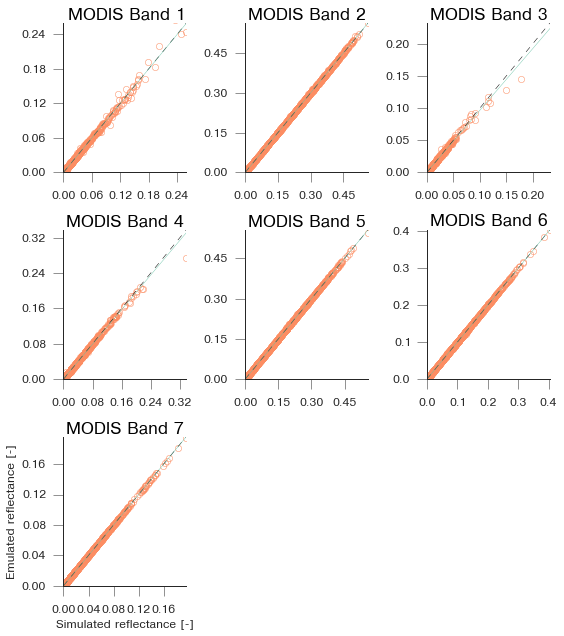

In [5]:
fig1, axs1 = plt.subplots ( nrows=3, ncols=3, figsize=(8,9))
#fig2, axs2 = plt.subplots ( nrows=4, ncols=3, figsize=(9,9))
axs1 = axs1.flatten()
#axs2 = axs2.flatten()
for iband in xrange ( 7):
    gp, validate, validate_output, validate_gradient, emulated_validation, emulated_gradient = retval[iband]

    slope, intercept, r_value, p_value, std_err = linregress( validate_output, emulated_validation.squeeze() )
    axs1[iband].plot ( validate_output, emulated_validation, 'o', mec="#FC8D62", mfc="none")
    ymax = np.max ( validate_output.max(), emulated_validation.max() )
    if iband == 2:
        ymax = ymax*1.3
    axs1[iband].plot ( [0, 1.2*ymax], [0, 1.2*ymax], 'k--', lw=0.5)
    p = np.polyfit ( validate_output, emulated_validation, 1)
    print "%d & %6.3f & %6.3f & %6.3f & %5g & %6.3f\\\\" % (iband+1, slope, intercept, r_value, p_value, std_err)
    x = np.linspace(0, 1.2*ymax, 5)
    axs1[iband].plot ( x, np.polyval ( p, x), '-', lw=0.4  )
    axs1[iband].set_ylim ( 0, ymax )
    axs1[iband].set_xlim ( 0, ymax )
    pretty_axes ( axs1[iband])
    axs1[iband].set_title ( "MODIS Band %d" % (iband+1))
    print
axs1[6].set_ylabel ( "Emulated reflectance [-]")
axs1[6].set_xlabel ( "Simulated reflectance [-]")
plt.tight_layout()     
axs1[7].set_visible (False)
axs1[8].set_visible (False)




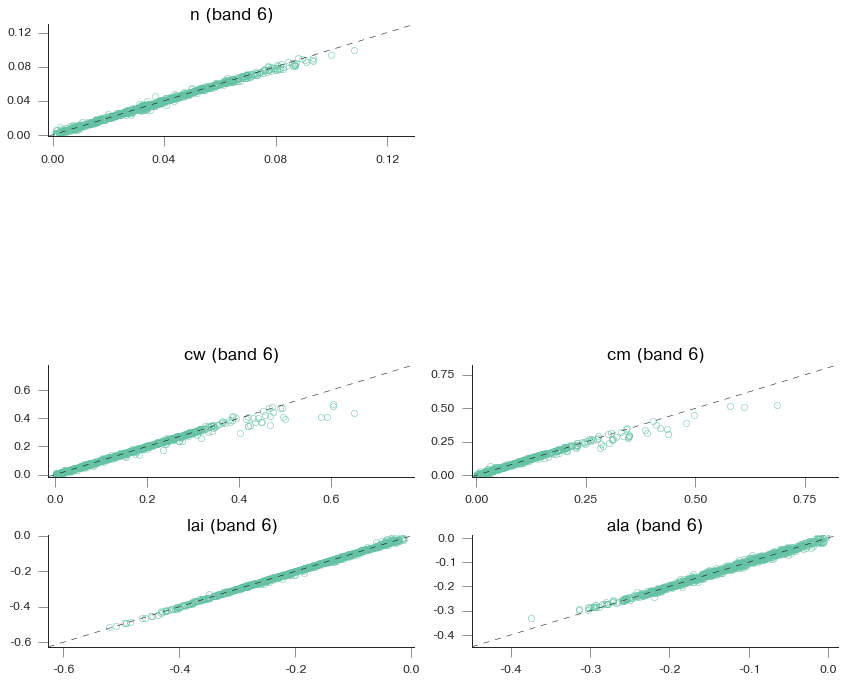

In [7]:
fig1, axs1 = plt.subplots ( nrows=5, ncols=2, figsize=(12,12))
#fig2, axs2 = plt.subplots ( nrows=4, ncols=3, figsize=(9,9))
axs1 = axs1.flatten()
#axs2 = axs2.flatten()
ignores = []
for iband in [5]:
    gp, validate, validate_output, validate_gradient, emulated_validation, emulated_gradient = retval[iband]

    for i in xrange ( 10):
        if len( np.unique(validate_gradient[:,i]) ) < 5:
            ignores.append ( i)
            continue
        x, y = validate_gradient[:, i], emulated_gradient[:, i]
        if iband == 1:
            axs1[i].plot ( x,y, 'o', mec="#FC8D62", mfc="none")
        elif iband == 5:
            axs1[i].plot ( x, y, 'o', mec="#66C2A5", mfc="none")
        ymax = max ( x.max(), y.max() )*1.2
        ymin = min ( x.min(), y.min() )*1.2
        axs1[i].set_xlim ( ymin, ymax)
        axs1[i].set_ylim ( ymin, ymax)
        axs1[i].plot( [ymin, ymax], [ymin, ymax], 'k--', lw=0.5 )
        axs1[i].set_title ( "%s (band %d)" % ( parameters[i], iband+1))
        pretty_axes ( axs1[i])
plt.tight_layout()
for i in ignores:
    axs1[i].set_visible ( False )


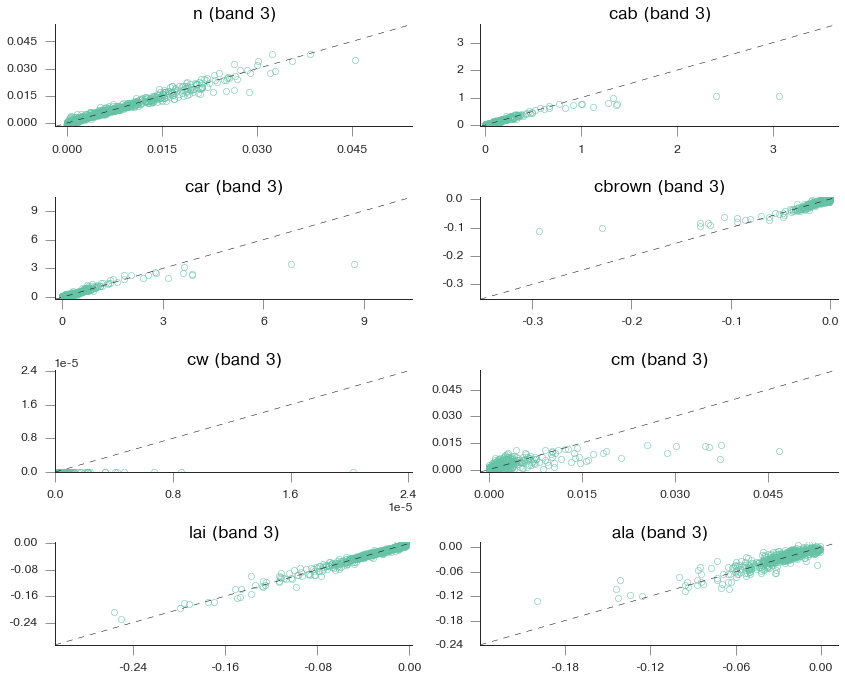

In [13]:
fig1, axs1 = plt.subplots ( nrows=5, ncols=2, figsize=(12,12))
#fig2, axs2 = plt.subplots ( nrows=4, ncols=3, figsize=(9,9))
axs1 = axs1.flatten()
#axs2 = axs2.flatten()
ignores = []
for iband in [2]:
    gp, validate, validate_output, validate_gradient, emulated_validation, emulated_gradient = retval[iband]

    for i in xrange ( 10):
        if len( np.unique(validate_gradient[:,i]) ) < 5:
            ignores.append ( i)
            continue
        x, y = validate_gradient[:, i], emulated_gradient[:, i]

        axs1[i].plot ( x, y, 'o', mec="#66C2A5", mfc="none")
        ymax = max ( x.max(), y.max() )*1.2
        ymin = min ( x.min(), y.min() )*1.2
        axs1[i].set_xlim ( ymin, ymax)
        axs1[i].set_ylim ( ymin, ymax)
        axs1[i].plot( [ymin, ymax], [ymin, ymax], 'k--', lw=0.5 )
        axs1[i].set_title ( "%s (band %d)" % ( parameters[i], iband+1))
        pretty_axes ( axs1[i])
plt.tight_layout()
for i in ignores:
    axs1[i].set_visible ( False )


## Spectral emulation

Perhaps monsieur would like a full spectrum emulation? We can easily do that by not subsetting the ``rt_model`` function, and letting ``gp_emulator`` create the emulator and validation set for you....

In [14]:
x = gp_emulator.create_emulator_validation ( rt_model, parameters, min_vals, max_vals, 
                                n_train, n_validate, do_gradient=True, 
                                n_tries=10, args=(30, 0, 0) )

Decomposing the input dataset into basis functions... Done!
 ====> Using 9 basis functions
	Fitting GP for basis function 0
After 10, the minimum cost was -3.635193e+02
	Fitting GP for basis function 1
After 10, the minimum cost was -6.172031e+02
	Fitting GP for basis function 2
After 10, the minimum cost was -5.076636e+02
	Fitting GP for basis function 3
After 10, the minimum cost was -5.786449e+02
	Fitting GP for basis function 4
After 10, the minimum cost was -7.481047e+02
	Fitting GP for basis function 5
After 10, the minimum cost was -8.612545e+02
	Fitting GP for basis function 6
After 10, the minimum cost was -7.905632e+02
	Fitting GP for basis function 7
After 10, the minimum cost was -8.050530e+02
	Fitting GP for basis function 8
After 10, the minimum cost was -9.293756e+02


/home/ucfajlg/.local/lib/python2.7/site-packages/gp_emulator/GaussianProcess.py:65: RuntimeWarning: invalid value encountered in multiply
  np.tile( self.inputs[:, d], (self.n, 1)).T))**2


So we now have an emulator for the model. Let's look at the residuals distribution with respect to wavelength, plotting the mean residual, and the 5-95% as well as the 25-75% posterior ranges:

([<matplotlib.axis.YTick at 0x7ff5b7eda110>,
 <a list of 5 Text yticklabel objects>)

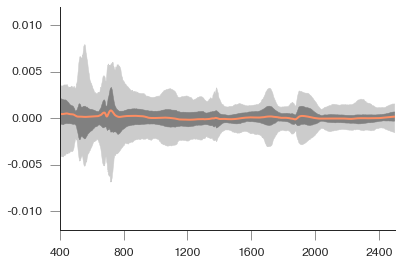

In [39]:
residual = x[2] - x[4]
wv = np.arange ( 400, 2501 )
plt.plot ( wv, residual.mean(axis=0))
plt.fill_between( wv, np.percentile( residual, 5, axis=0 ), 
                 np.percentile( residual, 95, axis=0 ), color="0.8")
plt.fill_between( wv, np.percentile( residual, 25, axis=0 ), 
                 np.percentile( residual, 75, axis=0 ), color="0.5")
plt.xlim(400,2500)
plt.ylim ( -0.012, 0.012)

pretty_axes(plt.gca())
plt.yticks([-0.01, -0.005, 0, 0.005, 0.01])


We see this as being a pretty good result, but with nevertheless still has some outliers in the light grey area. We ought to consider that the typical "noise" in the observations is of the order of 0.01 or thereabouts, so the emulation error is pretty low. Let's now test the gradient for e.g. Cab on the red region (650 nm) and LAI on the near infrared (865nm):

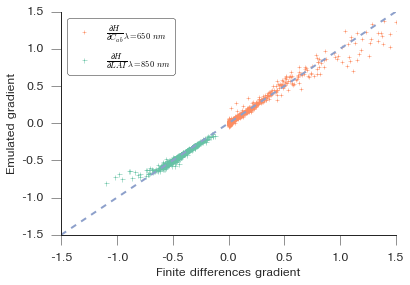

In [71]:
plt.plot ( x[3][:,1,250],  x[5][:, 1,250], '+', ms=4, label=r'$\frac{\partial H}{\partial C_{ab}}_{\lambda=650\,nm}$')
plt.plot ( x[3][:,6,465],  x[5][:,6,465], '+', ms=5, label=r'$\frac{\partial H}{\partial LAI}_{\lambda=850\,nm}$')
plt.xlim ( -1.5, 1.5)
plt.ylim ( -1.5, 1.5)
plt.plot([-1.5, 1.5], [-1.5, 1.5], '--' )
plt.xlabel ( "Finite differences gradient")
plt.ylabel("Emulated gradient")
plt.legend(loc='best', numpoints=1 )
pretty_axes(plt.gca())


Again, we see that the values are quite good except in the boundaries.